In [2]:
from __future__ import print_function, absolute_import, division
from keras import backend as K
from keras.engine.base_layer import Layer
from keras.engine.topology import InputSpec
import tensorflow as tf
from keras.layers.merge import Concatenate
from keras.utils import conv_utils
from keras.layers import Input, MaxPooling1D ,Conv1D,Activation,Dense, activations, initializers, Flatten, regularizers, constraints, Lambda,Dropout
from keras.layers import Input, MaxPooling1D ,Conv1D,Activation,Dense,   Flatten,   Lambda,Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.utils import plot_model
import numpy as np
from scipy.fftpack import dct
from keras.backend.common import normalize_data_format
from keras.layers.merge import Multiply
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler
from Gradient_Reverse_Layer import GradientReversal

In [4]:
class Attention(Layer):
    '''Custom Layer for ResNet used for BatchNormalization.

    Linear learnable weight vector , does dot multiplication on a vector
    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).'''

    def __init__(self, weights=None, axis=-1,init='he_normal',**kwargs):
        self.axis = axis
        self.init = initializers.get(init)
        self.kernel = weights
        super(Attention, self).__init__(**kwargs)
    def build(self, input_shape):
        if len(input_shape)>2:
            raise ValueError("Input to attention layer hasn't been flattened")
        self.input_dim = input_shape[-1]            
        self.kernel = self.add_weight(shape=(self.input_dim,),
                                      initializer=initializers.Ones(),
                                      name='kernel',
                                      constraint=constraints.NonNeg()
                                      #constraint=constraints.min_max_norm(min_value=0.0, max_value=1.0)
                                      #constraint=constraints.UnitNorm(axis=self.axis)
                                     )
        self.input_spec = InputSpec(min_ndim=2, axes={-1: self.input_dim})            
        self.built = True
    def call(self, inputs):
        output = tf.multiply(inputs,self.kernel)
        return output
    def compute_output_shape(self, input_shape):
        return input_shape
    def get_config(self):
        config = {"kernel": self.kernel, "axis": self.axis}
        base_config = super(Attention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [45]:
att = Attention(weights=[np.ones(10)],name = 'wow',trainable=True)

In [46]:
att.trainable

True

In [115]:
a = tf.convert_to_tensor(np.array([1,2,3]).astype(np.float32))
b = tf.convert_to_tensor(np.array([1,2,3]).astype(np.float32).reshape(1,3))
c = tf.convert_to_tensor(np.array([[1,2,3],[4,5,6]]).astype(np.float32).reshape(2,3))
a,b,c

(<tf.Tensor 'Const:0' shape=(3,) dtype=float32>,
 <tf.Tensor 'Const_1:0' shape=(1, 3) dtype=float32>,
 <tf.Tensor 'Const_2:0' shape=(2, 3) dtype=float32>)

In [8]:
out = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([a, b])

In [9]:
np.array(out)

array(<tf.Tensor 'lambda_1/mul:0' shape=(1, 3, 3) dtype=float32>,
      dtype=object)

In [10]:
out = tf.multiply(c,a)

In [13]:
out = Multiply()([b,b])

In [14]:
print((tf.Session().run(out)))

[[1. 4. 9.]]


In [49]:
att.get_weights()

[array([-0.1099719,  0.4618892,  0.4047528], dtype=float32)]

In [46]:
-.09050519+.05788201-.47705907

-0.50968225

In [50]:
att.get_config()

{'name': 'attention_6',
 'trainable': True,
 'kernel': <tf.Variable 'attention_6/kernel:0' shape=(3,) dtype=float32_ref>,
 'axis': -1}

In [120]:
print(list(range(25)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [3]:
def Network():
    input = Input(shape=(10, 1))
    t = Lambda(lambda x:x[:,:5,:])(input)
    t1 = Lambda(lambda x:x[:,5:,:])(input)
    t = Conv1D(3, kernel_size=1,
                kernel_initializer=initializers.he_normal(),
                padding='valid')(t)
    
    t1 = Conv1D(3, kernel_size=1,
                kernel_initializer=initializers.he_normal(),
                padding='valid')(t1)
    t = Concatenate(axis=1)([t,t1])
    t = Flatten()(t)
    #t1 = Flatten()(t1)
    opt = SGD(lr=.001,decay=.001)
    
    model = Model(inputs=input, outputs=t)
    model.compile(optimizer=opt, loss=['categorical_crossentropy'], metrics=['accuracy'])
    
#     model = Model(inputs=input, outputs=[t,t1])
#     model.compile(optimizer=opt, loss=['categorical_crossentropy','categorical_crossentropy'], metrics=['accuracy'])
    return model

In [4]:
model = Network()

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
model.summary()
#plot_model(model, to_file='model.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 5, 1)         0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 5, 1)         0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5, 3)         6           lambda_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (

In [6]:
model.get_layer('flatten_1').

In [10]:
from keras.models import load_model
help(load_model)

Help on function load_model in module keras.engine.saving:

load_model(filepath, custom_objects=None, compile=True)
    Loads a model saved via `save_model`.
    
    # Arguments
        filepath: one of the following:
            - string, path to the saved model, or
            - h5py.File or h5py.Group object from which to load the model
        custom_objects: Optional dictionary mapping names
            (strings) to custom classes or functions to be
            considered during deserialization.
        compile: Boolean, whether to compile the model
            after loading.
    
    # Returns
        A Keras model instance. If an optimizer was found
        as part of the saved model, the model is already
        compiled. Otherwise, the model is uncompiled and
        a warning will be displayed. When `compile` is set
        to False, the compilation is omitted without any
        warning.
    
    # Raises
        ImportError: if h5py is not available.
        ValueError: In

In [80]:
opt = SGD(lr=.001,decay=.001)
model = Model(inputs=inp, outputs=t)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

ValueError: Could not interpret optimizer identifier: None

In [10]:
x = np.random.rand(100,10,1)
y = np.random.randint(low = 0,high = 2,size = (100,1))
y = to_categorical(y,num_classes=2)

In [14]:
model.fit(x,[y,y],batch_size=10,epochs=5,verbose=1)

Epoch 1/5
100/100 [==============================] - 0s 266us/step - loss: 1.9940 - out_loss: 1.0740 - out2_loss: 0.9200 - out_acc: 0.4900 - out2_acc: 0.5400
Epoch 2/5
100/100 [==============================] - 0s 240us/step - loss: 1.8754 - out_loss: 0.9813 - out2_loss: 0.8941 - out_acc: 0.5000 - out2_acc: 0.4800
Epoch 3/5
100/100 [==============================] - 0s 233us/step - loss: 1.8163 - out_loss: 0.9265 - out2_loss: 0.8898 - out_acc: 0.5600 - out2_acc: 0.5100
Epoch 4/5
100/100 [==============================] - 0s 242us/step - loss: 1.9404 - out_loss: 1.0064 - out2_loss: 0.9341 - out_acc: 0.5000 - out2_acc: 0.4800
Epoch 5/5
100/100 [==============================] - 0s 266us/step - loss: 1.7900 - out_loss: 0.8932 - out2_loss: 0.8968 - out_acc: 0.5400 - out2_acc: 0.5400


In [53]:
model.get_layer("att" ).get_weights(),model.get_layer("att2" ).get_weights()

([array([1.0006565 , 0.9950268 , 1.0006152 , 0.9775875 , 0.99507576,
         1.0147973 , 0.9942441 , 0.9988031 , 0.96180874, 0.9970449 ],
        dtype=float32)],
 [array([0.9601198 , 0.99470335, 0.99289495, 0.9861508 , 0.9998297 ,
         0.9958785 , 0.96344477, 0.99211186, 0.9646526 , 0.9982504 ],
        dtype=float32)])

In [45]:
model.get_layer("att").trainable= False

In [129]:
a = tf.convert_to_tensor(np.random.rand(5,10).astype(np.float32))

In [130]:
att(a)

<tf.Tensor 'wow_19/Mul:0' shape=(5, 10) dtype=float32>

In [137]:
att.set_weights(model.get_layer("att" ).get_weights())

In [39]:
model.get_layer("att" ).set_kernel(model.get_layer("att2" ).kernel)

Setting kernel


In [42]:
a = model.get_layer("att2" ).kernel

In [1]:
def Confused_Crossentropy(y_true, y_pred):
    y_predfused = tf.multiply(y_pred,0)+.5
    #y_predfused = tf.convert_to_tensor((np.ones((batch,num_class),dtype=np.float32)*0.5))
    #y_truefused = tf.convert_to_tensor( to_categorical(np.ones(batch),num_class) )
    return K.abs(K.categorical_crossentropy(y_true, y_pred)-K.categorical_crossentropy(y_true,y_predfused))

In [16]:
to_categorical(0,num_classes=2)

array([1., 0.], dtype=float32)

In [18]:
def step_decay(epoch):             
    lr0 = .00128437
    #print("learning rate , lr 0 ", lr, lr0)
    a = 1
    b = 1
    p = epoch/epochs
    lrate = lr0/math.pow((1+a*p),b)
    return lrate
lrate = LearningRateScheduler(step_decay,verbose = 1)

In [11]:
def Network():
    input = Input(shape=(2900, 1))
    
    input1 = Lambda(lambda x:x[:,:200,:])(input)
    input2 = Lambda(lambda x:x[:,200:1000,:])(input)
    input3 = Lambda(lambda x:x[:,1000:1200,:])(input)
    input4 = Lambda(lambda x:x[:,1200:2900,:])(input)
    
    input1 = Flatten()(input1)
    input2 = Flatten()(input2)
    input3 = Flatten()(input3)
    input4 = Flatten()(input4)
    
    t1 = Dense(200)(input1)
    t2 = Dense(500)(input2)
    t3 = Dense(200)(input3)
    t4 = Dense(500)(input4)
    
    t = Concatenate(axis=1)([t1,t2,t3,t4])
    dann_in = GradientReversal(hp_lambda=.5,name='grl')(t)
    cls = Dense(2)(t)
    dom = Dense(8)(dann_in)
    #t1 = Flatten()(t1)
    opt = SGD(lr=.001,decay=.001)
    
    model = Model(inputs=input, outputs=[cls,dom])
    model.compile(optimizer=opt, loss=['categorical_crossentropy','categorical_crossentropy'], metrics=['accuracy'])
    
#     model = Model(inputs=input, outputs=[t,t1])
#     model.compile(optimizer=opt, loss=['categorical_crossentropy','categorical_crossentropy'], metrics=['accuracy'])
    return model

In [12]:
net = Network()

In [13]:
net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 2900, 1)      0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 200, 1)       0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 800, 1)       0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 200, 1)       0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_10 

In [28]:
import HeartCepNet
from HeartCepNet import heartnet, heartnet2D
import keras.backend as K
import numpy as np,matplotlib.pyplot as plt
import tensorflow as tf

In [9]:
net = heartnet2D(filters = 64,fs = fs)

In [10]:
wow = K.get_value(net.get_layer('gamma').impulse_gammatone())

In [26]:
wow

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.3473909e-09,  2.3472433e-09,  2.3467757e-09, ...,
        -2.2668767e-09, -2.3263609e-09, -2.3473909e-09],
       [ 1.8055964e-08,  1.8051418e-08,  1.8037039e-08, ...,
         1.5621207e-08,  1.7411811e-08,  1.8055964e-08],
       ...,
       [ 5.4157284e-05,  3.4713103e-05, -1.1553823e-05, ...,
        -3.6714534e-06, -2.8158311e-05,  5.4157281e-05],
       [ 5.4100303e-05,  3.4208555e-05, -1.2748634e-05, ...,
         1.7557211e-05,  2.1705859e-05, -5.4100299e-05],
       [ 5.4017401e-05,  3.3684522e-05, -1.3927543e-05, ...,
        -3.0196059e-05, -1.4869849e-05,  5.4017397e-05]], dtype=float32)

In [12]:
t,g,m=net.predict(sig)

In [27]:
g.shape

(1, 42701, 64)

In [15]:
g[0,:,[0]].shape

(1, 42701)

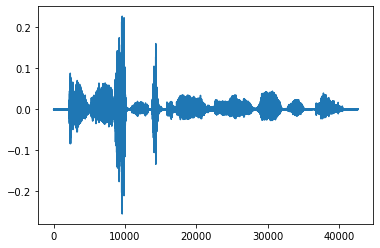

In [22]:
idx=60
plt.plot(g[0,:,[idx]].transpose())

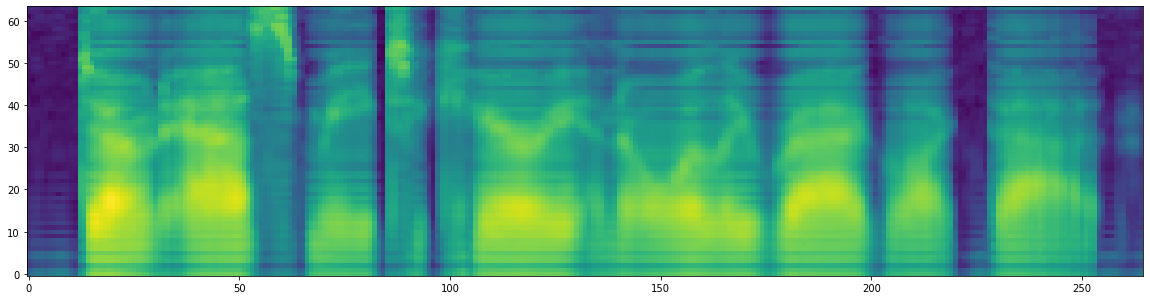

In [23]:
plt.figure(figsize=(20,20))
from matplotlib import cm
plt.imshow((g.squeeze(0).transpose()), interpolation='nearest', origin='lower')

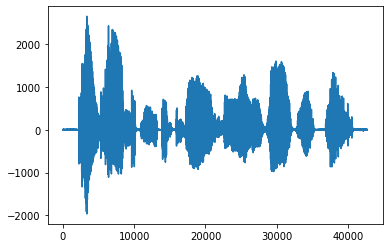

In [23]:
import scipy.io.wavfile as wav
import os
(fs,sig) = wav.read(os.path.join("..","gammatonegram","gammatonegram","sa2.wav"))
plt.plot(sig)

In [24]:
sig = np.expand_dims(np.expand_dims(sig,1),0)

In [31]:
amp = tf.convert_to_tensor(K.get_value(net.get_layer('gamma').amp))
fc = tf.convert_to_tensor(K.get_value(net.get_layer('gamma').fc))
beta = tf.convert_to_tensor(K.get_value(net.get_layer('gamma').beta))
t = tf.convert_to_tensor(K.get_value(net.get_layer('gamma').t))
n_order = tf.convert_to_tensor(K.get_value(net.get_layer('gamma').n_order))

In [33]:
gammatone = tf.multiply(tf.multiply(
            tf.matmul(amp, tf.pow(x=t, y=n_order - 1),
                      transpose_b=True),
            tf.exp(tf.multiply(-2 * np.pi, tf.matmul(beta, t,
                                                     transpose_b=True)))),
            tf.cos(tf.multiply(2 * np.pi, tf.matmul(fc, t,
                                                    transpose_b=True))))
gammatone = tf.transpose(gammatone)

In [59]:
at = K.get_value(tf.matmul(amp, tf.pow(x=t, y=n_order - 1),transpose_b=True))
exp = K.get_value(tf.exp(tf.multiply(-2 * np.pi, tf.matmul(beta, t,transpose_b=True))))
cos = K.get_value(tf.cos(tf.multiply(2 * np.pi, tf.matmul(fc, t,transpose_b=True))))

In [64]:
mm = K.get_value(tf.matmul(fc, t,transpose_b=True))

In [73]:
K.get_value(fc)

array([[   0.      ],
       [  28.567493],
       [  58.3009  ],
       [  89.2477  ],
       [ 121.45755 ],
       [ 154.98186 ],
       [ 189.87425 ],
       [ 226.19067 ],
       [ 263.98926 ],
       [ 303.33038 ],
       [ 344.27707 ],
       [ 386.89478 ],
       [ 431.25168 ],
       [ 477.41888 ],
       [ 525.4702  ],
       [ 575.48254 ],
       [ 627.5359  ],
       [ 681.7136  ],
       [ 738.10236 ],
       [ 796.7924  ],
       [ 857.87744 ],
       [ 921.4557  ],
       [ 987.6284  ],
       [1056.502   ],
       [1128.186   ],
       [1202.7955  ],
       [1280.4501  ],
       [1361.2734  ],
       [1445.3958  ],
       [1532.9509  ],
       [1624.0791  ],
       [1718.9265  ],
       [1817.6448  ],
       [1920.3917  ],
       [2027.3314  ],
       [2138.636   ],
       [2254.483   ],
       [2375.0576  ],
       [2500.5525  ],
       [2631.1697  ],
       [2767.1172  ],
       [2908.613   ],
       [3055.8823  ],
       [3209.1628  ],
       [3368.699   ],
       [35